# 20. 多智能体强化学习入门

## 20.1 简介
- 本书之前介绍的算法都是单智能体强化学习算法，其基本假设是动态环境是**稳态的**（stationary），即状态转移概率和奖励函数不变，并依此来设计相应的算法。而如果环境中还有其他智能体做交互和学习，那么任务则上升为**多智能体强化学习**（multi-agent reinforcement learning，MARL），如图 20-1 所示。

<div align="center" style="text-align: center;">
    <img src="./image/20-1.png" style="width: 60%;">
    <center>图 20-1 多智能体强化学习环境概览</center>
</div> 

- 多智能体的情形相比于单智能体更加复杂，因为每个智能体在和环境交互的同时也在和其他智能体进行直接或者间接的交互。因此，多智能体强化学习要比单智能体更困难，其难点主要体现在以下几点：
    - 由于多个智能体在环境中进行实时动态交互，并且每个智能体在不断学习并更新自身策略，因此在每个智能体的视角下，环境是**非稳态的**（non-stationary），即对于一个智能体而言，即使在相同的状态下采取相同的动作，得到的状态转移和奖励信号的分布可能在不断改变；
    - 多智能体的训练可能是多目标的，不同智能体需要最大化自己的利益；
    - 训练评估的复杂度会增加，可能需要大规模分布式训练来提高效率；

## 20.2 问题建模
- 将一个多智能体环境用一个元组 $(N, \mathcal{S, A, R}, P)$ 表示，其中 $N$ 是智能体的数目， $\mathcal{S} = S_1 \times \dots \times S_N$ 是所有智能体的状态集合，$\mathcal{A} = A_1 \times \dots \times A_N$ 是所有智能体的动作集合，$\mathcal{R} = r_1 \times \dots \times r_N$ 是所有只能以奖励函数的集合，$P$ 是环境的状态转移概率。一般多智能体强化学习的目标是为每个智能体学习一个策略来最大化其自身的累积奖励。

## 20.3 多智能体强化学习的基本求解范式
- 面对上述问题形式，最直接的想法是基于已经熟悉的单智能体算法来进行学习，这主要分为两种思路。
    - **完全中心化**（fully centralized）方法：将多个智能体进行决策当作一个超级智能体在进行决策，即把所有智能体的状态聚合在一起当作一个全局的超级状态，把所有智能体的动作连起来作为一个联合动作。这样做的好处是，由于已经知道了所有智能体的状态和动作，因此对这个超级智能体来说，环境依旧是稳态的，一些单智能体的算法的收敛性依旧可以得到保证。然而，这样的做法不能很好地扩展到智能体数量很多或者环境很大的情况，因为这时候将所有的信息简单暴力地拼在一起会导致维度爆炸，训练复杂度巨幅提升的问题往往不可解决。
    - 完全去中心化（fully decentralized）方法：与完全中心化方法相反的范式便是假设每个智能体都在自身的环境中独立地进行学习，不考虑其他智能体的改变。完全去中心化方法直接对每个智能体用一个单智能体强化学习算法来学习。这样做的缺点是环境是非稳态的，训练的收敛性不能得到保证，但是这种方法的好处在于随着智能体数量的增加有比较好的扩展性，不会遇到维度灾难而导致训练不能进行下去。

- 本章介绍完全去中心化方法，在原理解读和代码实践之后，进一步通过实验结果图看看这种方法的效果。第 21 章会进一步介绍进阶的多智能体强化学习的求解范式。

## 20.4 IPPO 算法
- 接下来将介绍一个完全去中心化的算法，此类算法被称为**独立学习**（independent learning）。由于对于每个智能体使用单智能体算法 PPO 进行训练，所因此这个算法叫作**独立 PPO**（Independent PPO，IPPO）算法。具体而言，这里使用的 PPO 算法版本为 PPO-截断，其算法流程如下：
    - 对于 $N$ 个智能体，为每个智能体初始化各自的策略以及价值函数
    - for 训练轮数 $k = 0,1,2 \dots$ do:
        - 所有智能体在环境中交互分别获得各自的一条轨迹数据
        - 对每个智能体，基于当前的价值函数用 GAE 计算优势函数的估计
        - 对每个智能体，通过最大化其 PPO-截断的目标来更新其策略
        - 对每个智能体，通过均方误差损失函数优化其价值函数
    - end for
    
## 20.5 IPPO 代码实践
- 下面介绍一下要使用的多智能体环境：`ma_gym` 库中的 Combat 环境。Combat 是一个在二维的格子世界上进行的两个队伍的对战模拟游戏，每个智能体的动作集合为：向四周移动 $1$ 格，攻击周围 $3 \times 3$ 格范围内其他敌对智能体，或者不采取任何行动。起初每个智能体有 3 点生命值，如果智能体在敌人的攻击范围内被攻击到了，则会扣 1 生命值，生命值掉为 0 则死亡，最后存活的队伍获胜。每个智能体的攻击有一轮的冷却时间。

- 在游戏中，我们能够控制一个队伍的所有智能体与另一个队伍的智能体对战。另一个队伍的智能体使用固定的算法：攻击在范围内最近的敌人，如果攻击范围内没有敌人，则向敌人靠近。图 20-2 是一个简单的 Combat 环境示例。

<div align="center" style="text-align: center;">
    <img src="./image/20-2.gif" style="width: 30%;">
    <center>图 20-2 Combat 环境示例</center>
</div> 

- 首先仍然导入一些需要用到的包，然后从 GitHub 中克隆 `ma-gym` 仓库到本地，并且导入其中的 Combat 环境。


In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import rl_utils
from tqdm import tqdm
import matplotlib.pyplot as plt

# ! git clone https://github.com/boyu-ai/ma-gym.git
import sys
sys.path.append("./ma-gym")
from ma_gym.envs.combat.combat import Combat

/home/wxl/anaconda3/envs/rl/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- 接下来的代码块与 12.4 节介绍过的 PPO 代码实践基本一致，不再赘述。

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return F.softmax(self.fc3(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return self.fc3(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()

        log_probs = torch.log(self.actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 1 - self.eps,
                            1 + self.eps) * advantage  # 截断
        actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()

- 现在进入 IPPO 代码实践的最主要部分。值得注意的是，在训练时使用了**参数共享**（parameter sharing）的技巧，即对于所有智能体使用同一套策略参数，这样做的好处是能够使得模型训练数据更多，同时训练更稳定。能够这样做的前提是，两个智能体是**同质的**（homogeneous），即它们的状态空间和动作空间是完全一致的，并且它们的优化目标也完全一致。感兴趣的读者也可以自行实现非参数共享版本的 IPPO，此时每个智能体就是一个独立的 PPO 的实例。

- 和之前的一些实验不同，这里不再展示智能体获得的回报，而是将 IPPO 训练的两个智能体团队的胜率作为主要的实验结果。接下来就可以开始训练 IPPO 了！

In [3]:
actor_lr = 3e-4
critic_lr = 1e-3
num_episodes = 100000
hidden_dim = 64
gamma = 0.99
lmbda = 0.97
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

team_size = 2
grid_size = (15, 15)
#创建Combat环境，格子世界的大小为15x15，己方智能体和敌方智能体数量都为2
env = Combat(grid_shape=grid_size, n_agents=team_size, n_opponents=team_size)

state_dim = env.observation_space[0].shape[0]
action_dim = env.action_space[0].n
#两个智能体共享同一个策略
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, eps,
            gamma, device)

win_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            transition_dict_1 = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            transition_dict_2 = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            s = env.reset()
            terminal = False
            while not terminal:
                a_1 = agent.take_action(s[0])
                a_2 = agent.take_action(s[1])
                next_s, r, done, info = env.step([a_1, a_2])
                transition_dict_1['states'].append(s[0])
                transition_dict_1['actions'].append(a_1)
                transition_dict_1['next_states'].append(next_s[0])
                transition_dict_1['rewards'].append(
                    r[0] + 100 if info['win'] else r[0] - 0.1)
                transition_dict_1['dones'].append(False)
                transition_dict_2['states'].append(s[1])
                transition_dict_2['actions'].append(a_2)
                transition_dict_2['next_states'].append(next_s[1])
                transition_dict_2['rewards'].append(
                    r[1] + 100 if info['win'] else r[1] - 0.1)
                transition_dict_2['dones'].append(False)
                s = next_s
                terminal = all(done)
            win_list.append(1 if info["win"] else 0)
            agent.update(transition_dict_1)
            agent.update(transition_dict_2)
            if (i_episode + 1) % 100 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(win_list[-100:])
                })
            pbar.update(1)

/home/wxl/anaconda3/envs/rl/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
Iteration 9: 100%|██████████| 10000/10000 [07:56<00:00, 20.98it/s, episode=100000, return=0.800]


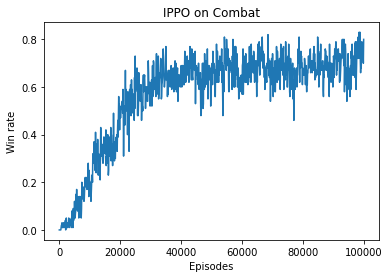

In [4]:
win_array = np.array(win_list)
#每100条轨迹取一次平均
win_array = np.mean(win_array.reshape(-1, 100), axis=1)

episodes_list = np.arange(win_array.shape[0]) * 100
plt.plot(episodes_list, win_array)
plt.xlabel('Episodes')
plt.ylabel('Win rate')
plt.title('IPPO on Combat')
plt.show()

- 可以看出，当智能体数量较少的时候，IPPO 这种完全去中心化学习在一定程度上能够取得好的效果，但是最终达到的胜率也比较有限。这可能是因为多个智能体之间无法有效地通过合作来共同完成目标。同时，好奇的读者也可以尝试增加智能体的数量，比较一下训练结果。当数量增加到 5 时，这种完全去中心化学习的训练效果就不是很好了。这时候可能就需要引入更多的算法来考虑多个智能体之间的交互行为，或者使用**中心化训练去中心化执行**（centralized training with decentralized execution，CTDE）的范式来进行多智能体训练，该方法将在第 21 章中详细介绍。

## 20.6 小结
- 本章介绍了多智能体强化学习的概念和两类基本的解决范式，并针对其中的完全去中心化方法进行了详细的介绍，讲解了一个具体的算法 IPPO，即用 PPO 算法为各个智能体训练各自的策略。在 Combat 环境中，我们共享了两个智能体之间的策略，以达到更好的效果。但这仅限于多个智能体同质的情况，若它们的状态空间或动作空间不一致，那便无法进行策略共享。